# Predicting Site Use by PFAS Composition
## Analysis, Result, Discussion and Conclusion

In [1]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
%matplotlib ipympl

In [2]:
# Import the data
df = pd.read_excel('cleaned_data.xlsx')
df 

,Site Name,Site Use,Date,Sample ID,Location ID,Latitude,Longitude,11ClPF3OUDS,4:2FTS,6:2FTS,...,PFNA,PFNDCA,PFOA,PFOS,PFOSA,PFPA,PFPES,PFTEDA,PFTRIDA,PFUNDCA
0,4-S Ranch WRF,Wastewater Treatment Plants,03/03/2021,BFP Cake,BFP CAKE,33.014402,-117.112003,0.019843,0.023307,0.059843,...,0.011969,0.007874,0.020787,0.056693,0.066142,0.020472,0.040945,0.066142,0.022677,0.020472
1,4-S Ranch WRF,Wastewater Treatment Plants,11/10/2020,BFP Cake,BFP CAKE,33.014402,-117.112003,0.019704,0.023153,0.059113,...,0.012315,0.007882,0.021182,0.054187,0.068966,0.020690,0.040394,0.064039,0.022660,0.020690
2,A.K. Warren Water Resource Facility,Wastewater Treatment Plants,01/06/2021,21010600414,JW_BS_CAKE,33.805270,-118.280636,0.011955,0.005978,0.011955,...,0.005978,0.034209,0.007178,0.168043,0.017885,0.005978,0.011955,0.005978,0.005978,0.005978
3,A.K. Warren Water Resource Facility,Wastewater Treatment Plants,04/07/2021,21040700441,JW_BS_CAKE,33.805270,-118.280636,0.022238,0.007410,0.014851,...,0.007410,0.014851,0.007410,0.110815,0.007410,0.007410,0.007410,0.014851,0.014851,0.007410
4,A.K. Warren Water Resource Facility,Wastewater Treatment Plants,07/06/2021,21070600411,JW_BS_CAKE,33.805270,-118.280636,0.022677,0.007564,0.015143,...,0.007564,0.016758,0.008994,0.050427,0.007564,0.007564,0.007564,0.015143,0.015143,0.007564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,Yreka City WWTP,Wastewater Treatment Plants,10/20/2021,21J0884-01 Biosolids,BIOSOLIDS,41.744100,-122.630730,0.019085,0.022453,0.056132,...,0.011507,0.025260,0.020208,0.053326,0.064552,0.028066,0.039293,0.061746,0.021611,0.019646
809,Yuba City WWTF,Wastewater Treatment Plants,03/18/2021,202103190266,BIO-001,39.108603,-121.612298,0.014537,0.048967,0.048967,...,0.014537,0.014537,0.014537,0.030604,0.014537,0.014537,0.073451,0.014537,0.014537,0.014537
810,Yuba City WWTF,Wastewater Treatment Plants,05/18/2021,202105190414,BIO-001,39.108603,-121.612298,0.014938,0.050088,0.050088,...,0.014938,0.014938,0.014938,0.028998,0.014938,0.014938,0.074692,0.014938,0.014938,0.014938
811,Yuba City WWTF,Wastewater Treatment Plants,08/25/2021,202108260557,BIO-001,39.108603,-121.612298,0.011602,0.034991,0.034991,...,0.011602,0.018416,0.013444,0.060773,0.013260,0.011602,0.011602,0.011602,0.011602,0.011602


## Dimensionality Reduction
There are 29 dimensions to this data, many of which are highly correlated. Lets use PCA and SVD to reduce that.

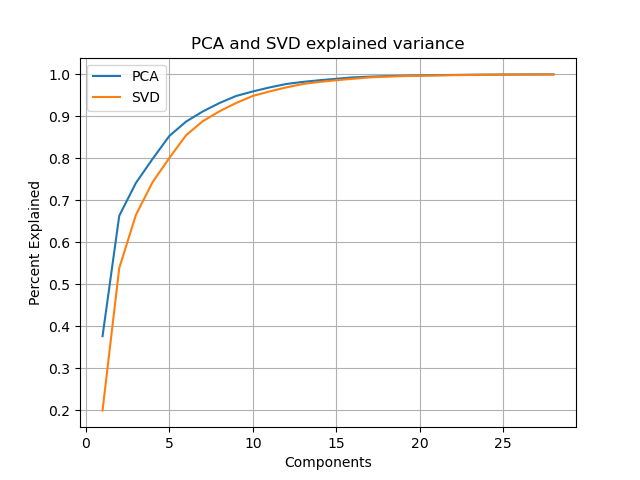

In [3]:
# get rid of the index columns
idx_length = 7
data = df[df.columns[idx_length :]].to_numpy()

# Initialize some variables
percent_explained_pca = []
percent_explained_svd = []

# get the max number of dimensions
max_componets = df.shape[1] - idx_length 
num_comps = list(range(1, max_componets))

# where 90%+ of the data is explained and the curve starts to level off
best_num_comps = 8

for i in num_comps:
    # Run the models and transform the data
    test_pca = PCA(n_components=i, random_state=42)
    test_pca.fit(data)
    percent_explained_pca.append(sum(test_pca.explained_variance_ratio_))

    test_svd = TruncatedSVD(n_components=i, random_state=42)
    test_svd.fit(data)
    percent_explained_svd.append(sum(test_svd.explained_variance_ratio_))

    # save best models for later
    if i == best_num_comps:
        pca = test_pca
        pca_data = pca.transform(data)

        svd = test_svd
        svd_data = svd.transform(data)


# make dataframes for each group for later use
df_idx = df[df.columns[:idx_length ]]

df_pca = pd.DataFrame(data = pca_data, columns = ['pca_%s' % i for i in range(best_num_comps)])
df_pca = pd.concat([df_idx, df_pca], axis = 1)

df_svd= pd.DataFrame(data = svd_data, columns = ['svd_%s' % i for i in range(best_num_comps)])
df_svd= pd.concat([df_idx, df_svd], axis = 1)

# plot it up!                       
plt.plot(num_comps, percent_explained_pca, label = 'PCA')
plt.plot(num_comps, percent_explained_svd, label = 'SVD')
plt.xlabel("Components")
plt.ylabel("Percent Explained")
plt.title('PCA and SVD explained variance')
plt.grid()
plt.legend()
plt.show()


## Multidimensional scaling

MDA is a dimension reduction technique used to visualize high dimensional data in lower dimensions. The idea is to maintain the distances between points in higher dimensions and then plot them in lower dimensions. 

From the sklearn documentation
"Multidimensional scaling (MDS) seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space. In general, MDS is a technique used for analyzing similarity or dissimilarity data. It attempts to model similarity or dissimilarity data as distances in a geometric spaces."  -- https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling


I will use it here to see if there is any difference in distribution between the PCA, SVD and untransformed data and if there are any observable clusters.



In [4]:
# Run the MDS on the 3 data sets
embedding = MDS(n_components=3, normalized_stress='auto', random_state=42)
pca_ploting_data = embedding.fit_transform(pca_data)
svd_ploting_data = embedding.fit_transform(svd_data)
normal_ploting_data = embedding.fit_transform(data)

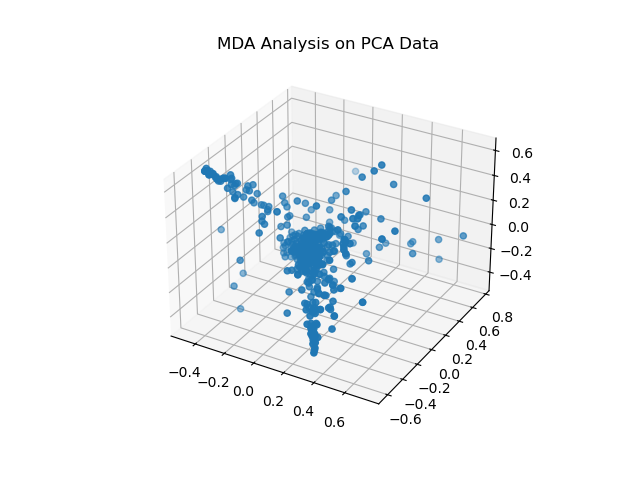

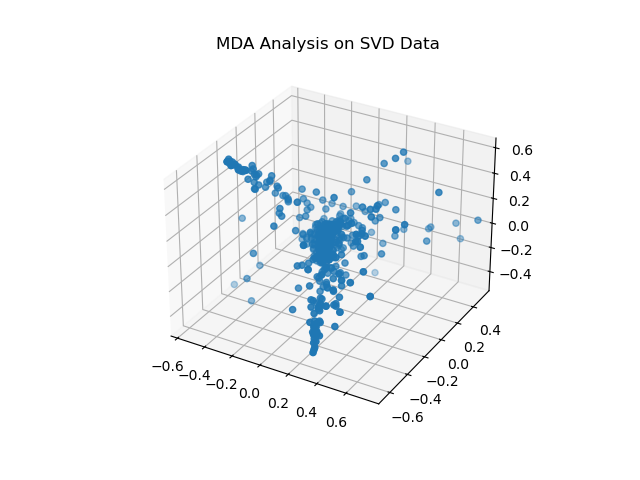

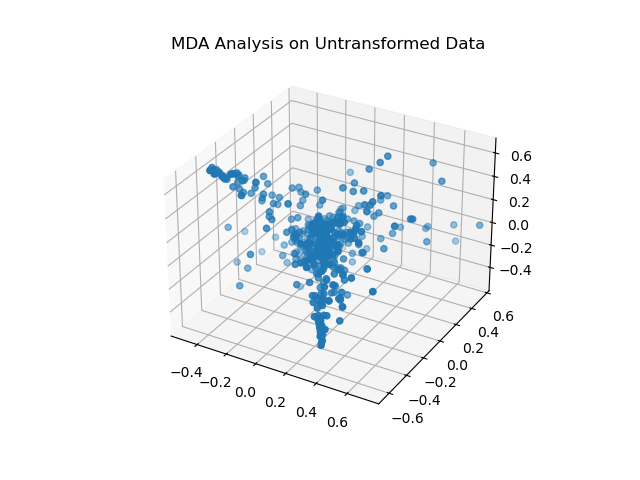

In [5]:
def make_3d_graph(data, title, groups = None, filter = None):
    """Makes a 3d graph of the data passed in. Data is a 3d numpy array, title is the title of the graph, groups 
    is an optional 1d numpy array if the points have groups assigned to them and filter is a 1d numpy array of indices to delete
    """
    # filter the data if needed
    if filter is not None:
        data = np.delete(data, filter, axis=0)
        groups = np.delete(groups, filter, axis=0)

    # get x, y and z 
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]

    # make the graph
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # add color to the groups if they exist
    if groups is not None:
        ax.scatter(x, y, z, c = groups)
    else:
        ax.scatter(x, y, z)

    # Set min and max values for axes
    ax.axes.set_xlim3d(left= min(x), right=max(x)) 
    ax.axes.set_ylim3d(bottom=min(y), top=max(y)) 
    ax.axes.set_zlim3d(bottom=min(z), top=max(z)) 
    ax.title.set_text(title)
    
    plt.show()

# Plot the graphs for each MDA
make_3d_graph(pca_ploting_data, 'MDA Analysis on PCA Data')
make_3d_graph(svd_ploting_data, 'MDA Analysis on SVD Data')
make_3d_graph(normal_ploting_data, 'MDA Analysis on Untransformed Data')

## Clustering

From the above graphs it looks like there are three clusters of data. Two "horns" and one main cluster in the center. I tried clustering with two through five clusters but to my eye three clusters fit the best so let's use KMeans to cluster the data. Why KMeans and not agglomerative clustering? Because KMeans partitions the space and allows you to predict with the model once you have trained it. Agglomerative clustering does not allow for that.



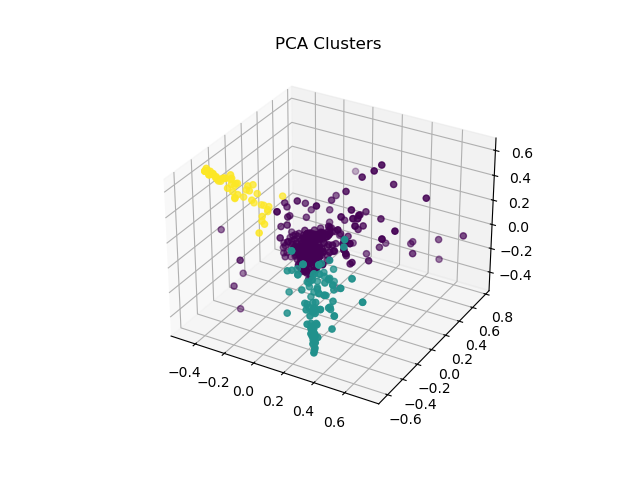

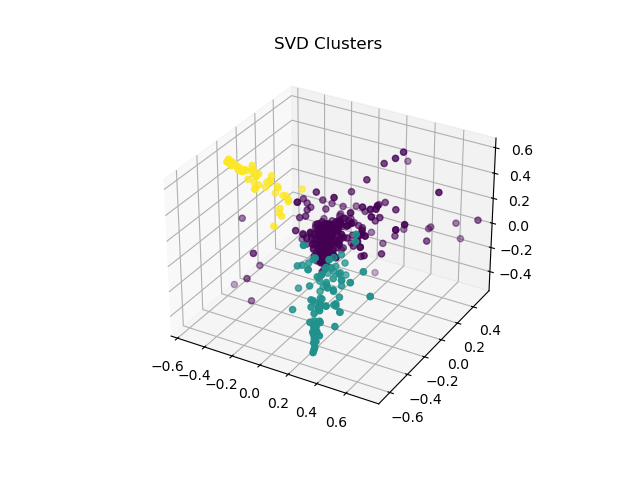

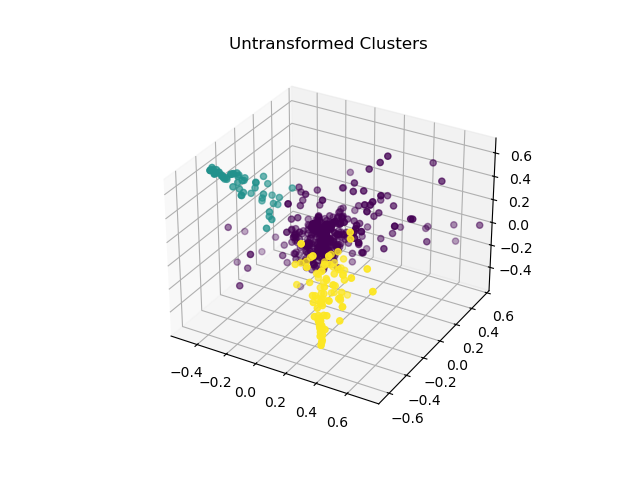

In [6]:
num_clusters = 3

# run the clustering algorithms
pca_clustering = KMeans(n_clusters=num_clusters, n_init = 'auto', random_state=42).fit(pca_data)
pca_groups = pca_clustering.labels_

svd_clustering = KMeans(n_clusters=num_clusters, n_init = 'auto', random_state=42).fit(svd_data)
svd_groups = svd_clustering.labels_

normal_clustering = KMeans(n_clusters=num_clusters, n_init = 'auto', random_state=42).fit(data)
normal_groups = normal_clustering.labels_

# save the values in a dataframe for later
df['pca_groups'] = pca_groups
df['svd_groups'] = svd_groups
df['normal_groups'] = normal_groups

# plot some graphs
make_3d_graph(pca_ploting_data, 'PCA Clusters', groups = pca_groups)
make_3d_graph(svd_ploting_data, 'SVD Clusters', groups = svd_groups)
make_3d_graph(normal_ploting_data, 'Untransformed Clusters', groups = normal_groups)

PCA clustering gave an accuracy of 0.4403444034440344 compared to site use groups


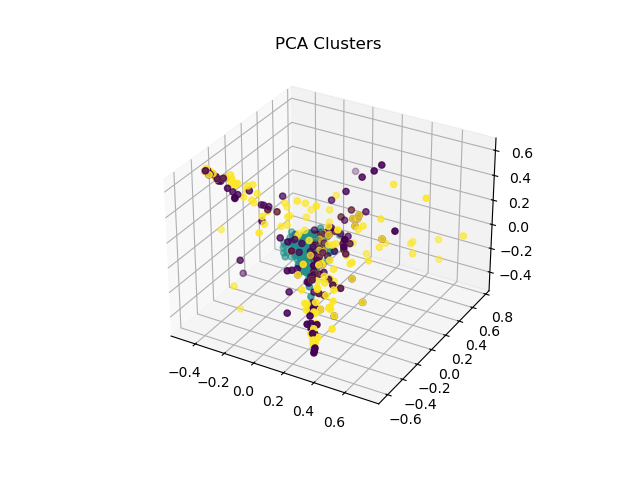

SVD clustering gave an accuracy of 0.4403444034440344 compared to site use groups


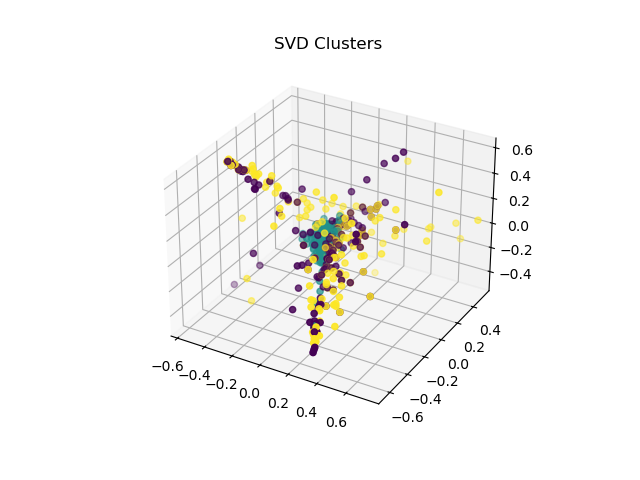

Untransformed clustering gave an accuracy of 0.44157441574415746 compared to site use groups


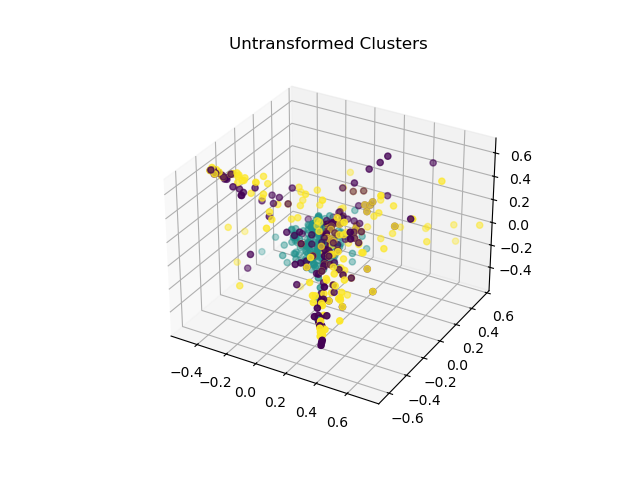

In [7]:
def label_permute_compare(true_, predicted, filter = None):
    """Gets the combination of labels that results in the highest accuracy. Modified from week 2."""

    # filter the data if needed
    if filter is not None:
        true_ = np.delete(true_, filter, axis=0)
        predicted = np.delete(predicted, filter, axis=0)

    # get all combinations
    perms = itertools.permutations(np.unique(true_))

    # find the best order and calculate the accuracy
    acc = 0.0
    best_order = 0
    for perm in perms:
        pred = [perm[i] for i in predicted]
        pred_acc = sum([1 for x, y, in zip(list(true_), pred) if x == y]) / len(true_)
        if pred_acc > acc:
            acc = pred_acc
            best_order = perm
            
    return acc, best_order

# assign values to each of the site use categories
use_dict = {'Airport':0, 'Wastewater Treatment Plants':1, 'Industrial - Bulk Fuel Terminal/Refinery':2}
# convert the string labels to ints
df['site_use_groups'] = df['Site Use'].apply(lambda val: use_dict.get(val, 3))

# get the index of any values that aren't in the 3 main groups so they can be deleted.
site_use_groups = df.site_use_groups.to_numpy()
del_idx = np.argwhere(site_use_groups == 3)

# See if the clustering can accurately determine the site usage
pca_acc, _ = label_permute_compare(site_use_groups, pca_groups, filter = del_idx)
print("PCA clustering gave an accuracy of %s compared to site use groups" % pca_acc)
make_3d_graph(pca_ploting_data, 'PCA Clusters', groups = site_use_groups, filter = del_idx)

svd_acc, _ = label_permute_compare(site_use_groups, svd_groups, filter = del_idx)
print("SVD clustering gave an accuracy of %s compared to site use groups" % svd_acc)
make_3d_graph(svd_ploting_data, 'SVD Clusters', groups = site_use_groups, filter = del_idx)


normal_acc, _ = label_permute_compare(site_use_groups, normal_groups, filter = del_idx)
print("Untransformed clustering gave an accuracy of %s compared to site use groups" % normal_acc)
make_3d_graph(normal_ploting_data, 'Untransformed Clusters', groups = site_use_groups, filter = del_idx)


## Model discussion and results

Looks like the accuracy for all models is around 44%. Which is better than random chance, but not good. Why is that?

First it's important to think about what the clusters are representing. They are the ratios of PFAS found in a soil sample. That means that they are likely representing different products that were spilled at these sites. For example my suspicion is that one cluster represents AFFF (Aqueous film-forming foam, a firefighting foam used at refineries and airports that has a high amount of PFAS in it), another oil related PFAS products and the third cluster is likley biosolids found at a wastewater treatment plant. That could be confirmed by finding the ratio of PFAS in each of those products and comparing it to the cluster centroids but that is outside the scope of this assignment.

Second is a one to many relationship between a site and the number of samples at that site, as well as a one to many relationship between a site and products used at that site. So one site could have taken multiple samples and those samples could belong to different groups. For example an airport could have spilled fuel in one area (cluster B) and have used AFFF in another area (cluster A) and therfore be represented in both clusters.

That would result in one site appearing in multiple clusters in my graph and causing the low accuracy result. Interesting since I would expect airports and fuel refineries to have similar characteristics (they both have oil products and use AFFF) but be dissimilar to wastewater treatment plants that could explain the 44% accuracy score. I think the model is accurately identifying wastewater treatment plants but confusing the airports and refineries. That's why the score is above the 33% expected if it were truly random.

One possible way out of this conundrum would be to take the average ratio for all samples across a site and use our trained K Means model to cluster it. Although airports and refineries both use similar products they probably don’t use them in the same proportions. So an average value for each site first solves the one to many relationship issues between site usage and the clusters, and takes into account the amount of product used at each site.


Accuracy for all models was 0.91


Text(0.5, 1.0, 'Untransformed')

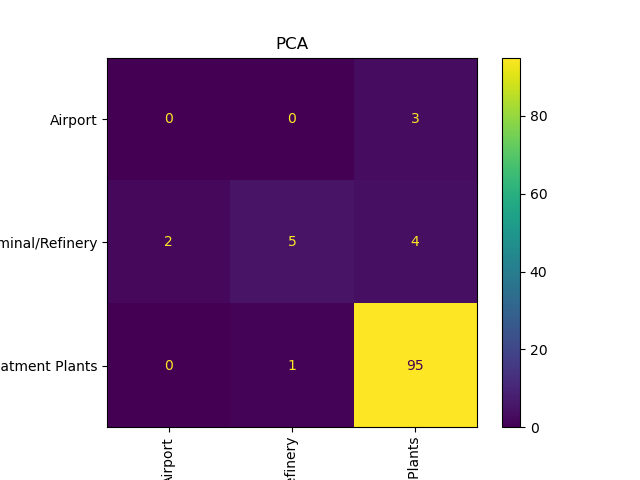

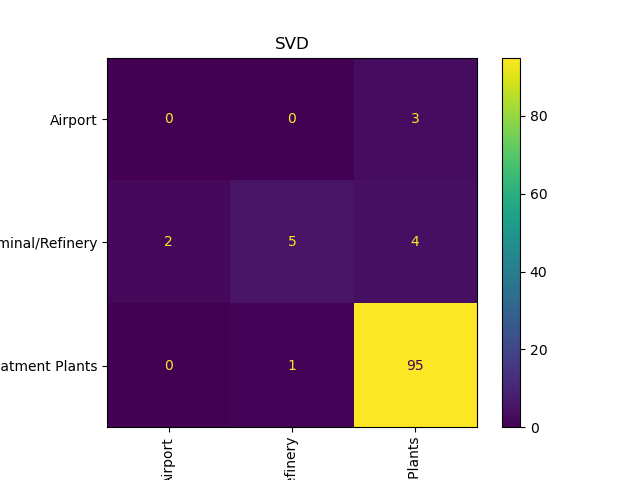

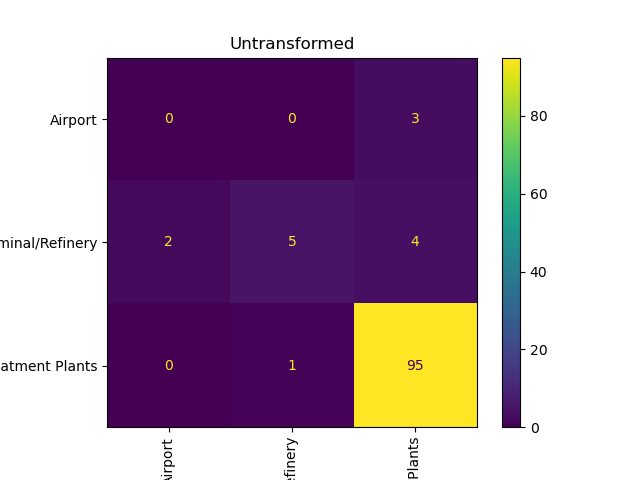

In [8]:
# get the site usage for each site
site_name_use_dict = {}
for site_name in df['Site Name'].unique():
    df_temp = df[df['Site Name'] == site_name]
    site_name_use_dict[site_name] = df_temp['Site Use'].unique()[0]

# Group the data by site name and get an average value for each pfas component
df_site_groups = df.drop(columns = ['Date', 'Site Use',  'Sample ID', 'Location ID', 'Latitude', 'Longitude',
                                    'pca_groups', 'svd_groups', 'normal_groups', 'site_use_groups'])
df_site_groups = df_site_groups.groupby('Site Name').mean().reset_index()
test_data = df_site_groups[df_site_groups.columns[1:]].to_numpy()

# Get the site usage for each site
true_y = df_site_groups['Site Name'].apply(lambda val: site_name_use_dict.get(val))

# Transform the grouped data using the already trained dimension reduction techniques
pca_test_data = pca.transform(test_data)
svd_test_data = svd.transform(test_data)

# See what the predictions are
pca_y = pca_clustering.predict(pca_test_data)
svd_y = svd_clustering.predict(svd_test_data)
normal_y = normal_clustering.predict(test_data)

# Get the accuracy and convert the predicted groups labels to the labels defined in the use_dict
pca_acc, pca_best_order = label_permute_compare(true_y, pca_y)
svd_acc, svd_best_order = label_permute_compare(true_y, svd_y)
normal_acc, normal_best_order = label_permute_compare(true_y, normal_y)

pca_y = [pca_best_order[idx] for idx in pca_y]
svd_y = [svd_best_order[idx] for idx in svd_y]
normal_y = [normal_best_order[idx] for idx in normal_y]


# graph it
print('Accuracy for all models was %s' % round(pca_acc, 2))
cmd = ConfusionMatrixDisplay.from_predictions(true_y, pca_y, xticks_rotation="vertical")
cmd.ax_.set_title('PCA')

cmd = ConfusionMatrixDisplay.from_predictions(true_y, svd_y, xticks_rotation="vertical")
cmd.ax_.set_title('SVD')

cmd = ConfusionMatrixDisplay.from_predictions(true_y, normal_y, xticks_rotation="vertical")
cmd.ax_.set_title('Untransformed')

The models show a high accuracy! However that is in part due to the fact that the group by unbalanced the data set. Although the number of samples for site use is balanced there are only a small number of airports and refineries that were sampled. The model still appears to have some trouble distinguishing between airports and refineries. However I do think the results are promising but to really investigate I would need a more balanced dataset. 

## Supervised learning 
Let's investigate the relationship I found between products now. Now that I have used clustering to assign the samples to a class, let's see if I can use supervised learning to distinguish between them.  I’ll use an SVM since the methodology behind SMVs should work well with clustering.

SVM with PCA transformed data has an accuracy of 0.9925650557620818
SVM with SVD transformed data has an accuracy of 0.9925650557620818
SVM with untransformed data has an accuracy of 0.9888475836431226


Text(0.5, 1.0, 'Untransformed Data')

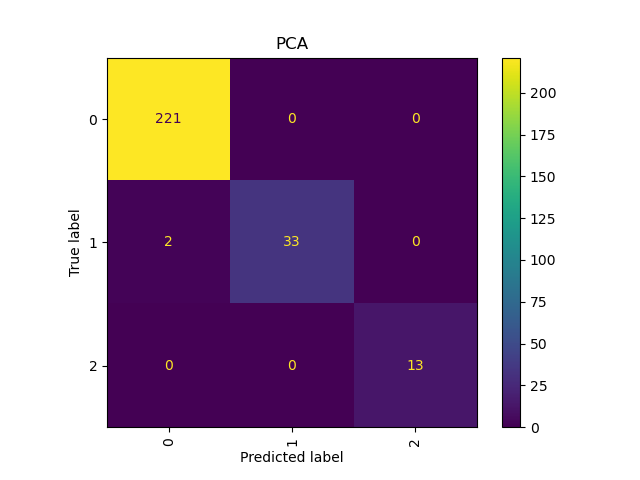

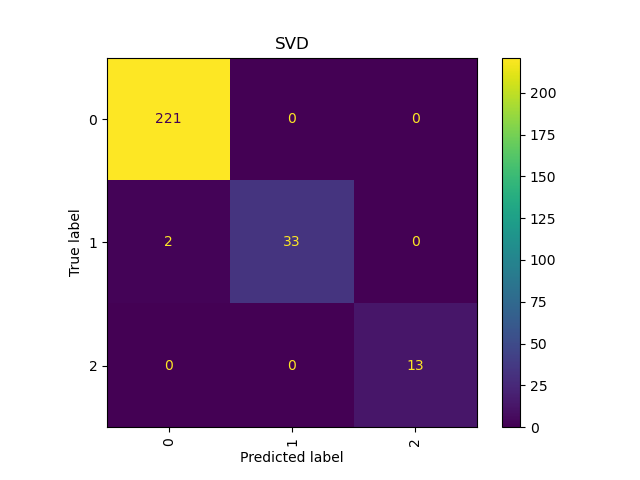

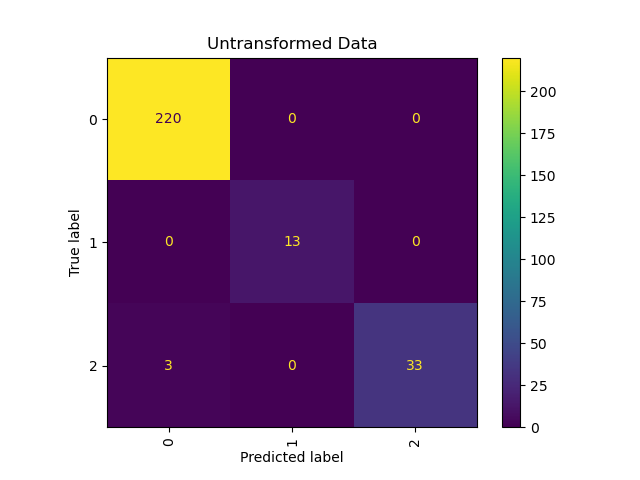

In [9]:
# split the data
pca_x_train, pca_x_test, pca_y_train, pca_y_test = train_test_split(pca_data, pca_groups, test_size=0.33, random_state=42)
svd_x_train, svd_x_test, svd_y_train, svd_y_test = train_test_split(svd_data, svd_groups, test_size=0.33, random_state=42)
normal_x_train, normal_x_test, normal_y_train, normal_y_test = train_test_split(data, normal_groups, test_size=0.33, random_state=42)

# make the models
pca_svm = SVC(kernel='linear')
svd_svm = SVC(kernel='linear')
normal_svm = SVC(kernel='linear')

# fit the models
pca_svm.fit(pca_x_train, pca_y_train)
svd_svm.fit(svd_x_train, svd_y_train)
normal_svm.fit(normal_x_train, normal_y_train)

# and make some predictions
pca_y = pca_svm.predict(pca_x_test)
svd_y = svd_svm.predict(svd_x_test)
normal_y = normal_svm.predict(normal_x_test)

# Graph the results!
print('SVM with PCA transformed data has an accuracy of %s' % accuracy_score(pca_y_test, pca_y))
cmd = ConfusionMatrixDisplay.from_predictions(pca_y_test, pca_y, xticks_rotation="vertical")
cmd.ax_.set_title('PCA')

print('SVM with SVD transformed data has an accuracy of %s' % accuracy_score(svd_y_test, svd_y))
cmd = ConfusionMatrixDisplay.from_predictions(svd_y_test, svd_y, xticks_rotation="vertical")
cmd.ax_.set_title('SVD')

print('SVM with untransformed data has an accuracy of %s' % accuracy_score(normal_y_test, normal_y))
cmd = ConfusionMatrixDisplay.from_predictions(normal_y_test, normal_y, xticks_rotation="vertical")
cmd.ax_.set_title('Untransformed Data')

## Supervised Learning Results

Ok, all the models have an accuracy of 99 or 98 percent. That means that SVM using a linear kernel was able to find a division between the classes, which adds some confirmation that the relationship between the classes is real. A further option to investigate this would be to see if a random forest could produce similar results since it operates on a very different principle than SVM or clustering. If it did that would be stronger evidence of a real relationship in the data. 

# Conclusion

Using PCA and SVD as dimension reduction and MDA for visualization I am able to determine that there are three clusters in the data. Each cluster likely represents a different product that was spilled at a site. By grouping all the samples taken at a site and getting an average chemical signature for that site I am able to predict site use by assigning that average signature to one of the three clusters. Using supervised learning I further confirmed that there is a real relationship between the clusters. Other possible ideas to continue this would be to find a more balanced data set with an equal number of sites tested per site use, using the cluster centroids to confirm which product each group represents and seeing if random forest can find the same divisions in the data as the clustering and SVD methods.
